# Importing Libraries

In [1]:
import os
from dotenv import load_dotenv
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# PyTorch
import torch

# Huggingface
import huggingface_hub
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM

# Weights & Biases
import wandb

# Hyperparameters

In [2]:
@dataclass
class CONFIG:
    debug: bool = False
    
    # Model
    model_type: str = "base"  # "base", "instruct"
    model_size: str = "1B"  # "1B", "3B"
    if model_type == "base":
        if model_size == "1B":
            model_id: str = "meta-llama/Llama-3.2-1B"
        elif model_size == "3B":
            model_id: str = "meta-llama/Llama-3.2-3B"
    elif model_type == "instruct":
        if model_size == "1B":
            model_id: str = "meta-llama/Llama-3.2-1B-Instruct"
        elif model_size == "3B":
            model_id: str = "meta-llama/Llama-3.2-3B-Instruct"

    # HuggingFace Hub
    username: str = "PathFinderKR"
    model_name: str = f"Llama-3.2-KO-{model_size}-Instruct"
    repo_id: str = f"{username}/{model_name}"
    
    # Data
    dataset_id: str = "MarkrAI/KOpen-HQ-Hermes-2.5-60K"
    validation_size: float = 0.1
    
    # Training
    output_dir: str = "./results"
    logging_dir: str = "./logs"
    save_strategy: str = "epoch"
    logging_strategy: str = "steps"
    logging_steps: int = 10
    save_total_limit: int = 1
    report_to: str = "wandb" if not debug else None
    
    num_train_epochs: int = 1
    per_device_train_batch_size: int = 2
    gradient_accumulation_steps: int = 4
    gradient_checkpointing: bool = True
    bf16: bool = True
    learning_rate: float = 2e-5
    lr_scheduler_type: str = "cosine"
    warmup_ratio: float = 0.1
    optim: str = "adamw_torch"
    weight_decay: float = 0.01
    max_seq_length: int = 4086
    
    # Inference
    max_new_tokens: int = 128000
    do_sample: bool = True
    temperature: float = 0.7
    top_p: float = 0.9
    repetition_penalty: float = 1.1
    
    # Device
    device: torch.device = None
    attn_implementation: str = None
    torch_dtype: torch.dtype = torch.bfloat16
    
    # Seed
    seed: int = 42

# Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f"Seed: {seed}")
    
set_seed(CONFIG.seed)

Seed: 42


# Device

In [4]:
def configure_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        num_gpu = torch.cuda.device_count()
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", num_gpu)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("> Running on MPS")
    else:
        device = torch.device("cpu")
        print("> Running on CPU")
    return device

CONFIG.device = configure_device()

> Running on GPU | Num of GPUs:  1


In [5]:
def configure_attn_implementation(device):
    if device == "cuda":
        if torch.cuda.get_device_capability()[0] >= 8: # Ampere, Ada, or Hopper GPUs
            attn_implementation = "flash_attention_2"
        else:
            attn_implementation = "eager"
    else:
        attn_implementation = None
    return attn_implementation

CONFIG.attn_implementation= configure_attn_implementation(CONFIG.device)

# Debugging

In [6]:
if CONFIG.debug:
    CONFIG.num_train_epochs = 1

# HuggingFace

In [7]:
load_dotenv()
huggingface_hub.login(
    token=os.getenv("HUGGINGFACE_TOKEN"),
    add_to_git_credential=True
)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/pathfinder/.cache/huggingface/token
Login successful


# Weights & Biases

In [8]:
if not CONFIG.debug:
    wandb.login(
        key=os.getenv("WANDB_API_KEY")
    )
    wandb.init(
        project=CONFIG.model_name,
    )

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pathfinderkr. Use `wandb login --relogin` to force relogin


# Utility Functions

In [9]:
def generate_base_model(prompt):
    input_ids = tokenizer.encode(
        prompt,
        add_special_tokens=True,
        return_tensors="pt"
    ).to(CONFIG.device)
    
    output = model.generate(
        input_ids,
        max_new_tokens=CONFIG.max_new_tokens,
        do_sample=CONFIG.do_sample,
        temperature=CONFIG.temperature,
        top_p=CONFIG.top_p,
        repetition_penalty=CONFIG.repetition_penalty,
        streamer=streamer
    )
    
    return tokenizer.decode(output[0], skip_special_tokens=False)

In [10]:
# Llama-3-Instruct template
def prompt_template(system, user):
    return (
        "<|start_header_id|>system<|end_header_id|>\n\n"
        f"{system}<|eot_id|>"
        
        "<|start_header_id|>user<|end_header_id|>\n\n"
        f"{user}<|eot_id|>"
        
        "<|start_header_id|>assistant<|end_header_id|>\n\n"
    )

def generate_instruct_model(system, user):
    prompt = prompt_template(system, user)
    
    input_ids = tokenizer.encode(
        prompt,
        add_special_tokens=True,
        return_tensors="pt"
    ).to(CONFIG.device)
    
    outputs = model.generate(
        input_ids=input_ids,
        max_new_tokens=CONFIG.max_new_tokens,
        do_sample=CONFIG.do_sample,
        temperature=CONFIG.temperature,
        top_p=CONFIG.top_p,
        repetition_penalty=CONFIG.repetition_penalty,
        streamer=streamer
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=False)

In [11]:
# Alpaca dataset format: 
# {"input": [str],
#  "instruction": [str],
#   "output": [str]}

def prompt_without_input(example):
    text = (
        f"<|start_header_id|>user<|end_header_id|>\n\n"
        f"{example['instruction']}<|eot_id|>"
        
        f"<|start_header_id|>assistant<|end_header_id|>\n\n"
        f"{example['output']}"
    )
    return {'text': text}
    
def prompt_with_input(example):
    text = (
        f"<|start_header_id|>system<|end_header_id|>\n\n"
        f"{example['input']}<|eot_id|>"
        
        f"<|start_header_id|>user<|end_header_id|>\n\n"
        f"{example['instruction']}<|eot_id|>"
        
        f"<|start_header_id|>assistant<|end_header_id|>\n\n"
        f"{example['output']}"
    )
    return {'text': text}
    
def formatting_func(example):
    # if input is not provided
    if example["input"] == "":
        return prompt_without_input(example)
    # if input is provided
    else:
        return prompt_with_input(example)

In [12]:
def plot_token_length(fields):
    for field in fields:
        token_lengths = [len(tokenizer.encode(example[field])) for example in dataset["train"] if example[field] != ""]
        
        plt.figure(figsize=(10, 5))
        plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
        plt.xlabel(f'{field.capitalize()} Length')
        plt.ylabel('Frequency')
        plt.title(f'{field.capitalize()} Token Length Distribution')
        plt.show()
        
        print(f"Max {field} token length: {max(token_lengths)}")
        print(f"Min {field} token length: {min(token_lengths)}")
        print(f"Mean {field} token length: {np.mean(token_lengths):.2f}")
        print(f"Standard deviation of {field} token length: {np.std(token_lengths):.2f}")

# Tokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(
    CONFIG.model_id,
    padding_side="right"
)
tokenizer.pad_token_id = tokenizer.eos_token_id
streamer = TextStreamer(tokenizer)

In [14]:
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Special tokens: {tokenizer.all_special_tokens}")

Vocabulary size: 128000
Special tokens: ['<|begin_of_text|>', '<|end_of_text|>']


# Model

In [15]:
model = AutoModelForCausalLM.from_pretrained(
    CONFIG.model_id,
    device_map=CONFIG.device,
    attn_implementation=CONFIG.attn_implementation,
    torch_dtype=CONFIG.torch_dtype,
    use_cache=False
)

In [16]:
print(model)
print(f"Number of parameters: {model.num_parameters() / 1e9:.2f}B")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [17]:
if CONFIG.debug:
    sample_text = "Machine learning:"
    sample_generated_text = generate_base_model(sample_text)
    print(sample_generated_text)

# Dataset

In [18]:
dataset = load_dataset(CONFIG.dataset_id)

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'instruction', 'output'],
        num_rows: 60061
    })
})

In [20]:
print(f"input:\n{dataset['train'][0]['input']}")
print(f"instruction:\n{dataset['train'][0]['instruction']}")
print(f"output:\n{dataset['train'][0]['output']}")

input:
귀하는 항상 설명을 제공하는 도움이 되는 조수입니다. 5살짜리 아이에게 대답한다고 생각하세요.
instruction:
Review:
자비로운 속임수에 대한 씁쓸한 현대 코미디 , 영화 제작자의 시대 작품에 필적하지는 않지만 여전히 볼만한 가치가 있습니다.
이 영화 리뷰 문장이 부정적인가요, 긍정적인가요?
output:
이 영화 리뷰 문장은 대부분 긍정적입니다. 리뷰어는 이 영화가 달콤함과 재미가 잘 어우러져 있으며, 감독의 다른 영화만큼 훌륭하지는 않지만 여전히 볼 만한 가치가 있다고 평가합니다.


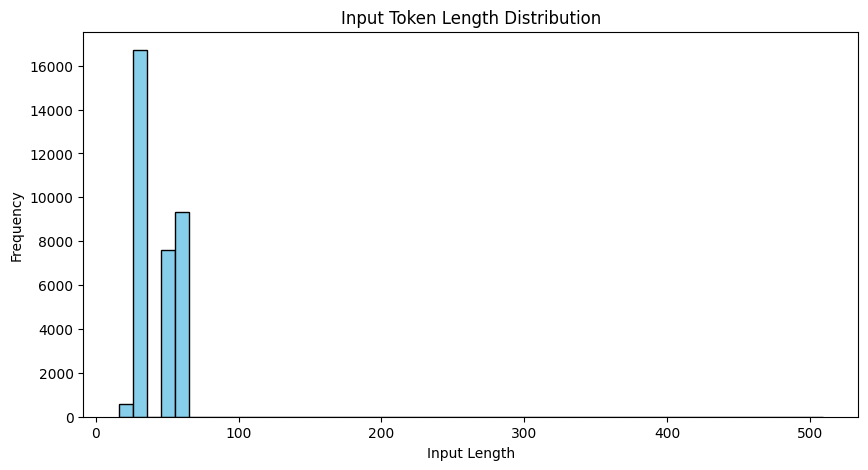

Max input token length: 509
Min input token length: 16
Mean input token length: 43.47
Standard deviation of input token length: 18.82


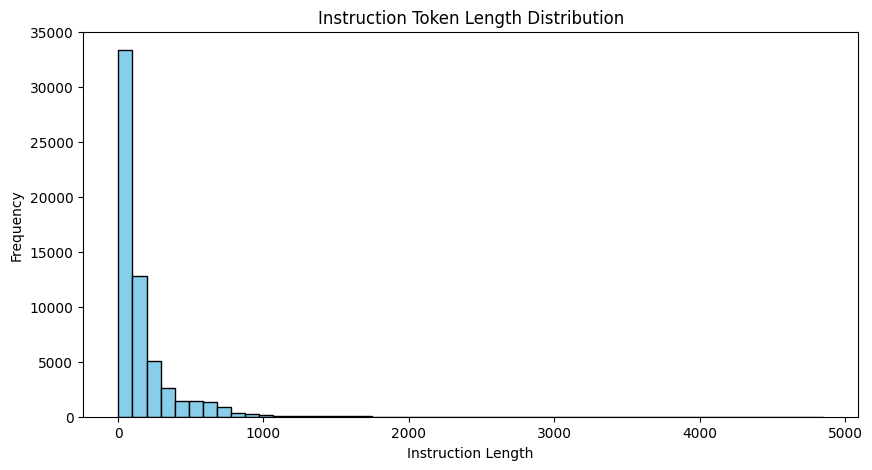

Max instruction token length: 4848
Min instruction token length: 2
Mean instruction token length: 162.42
Standard deviation of instruction token length: 216.83


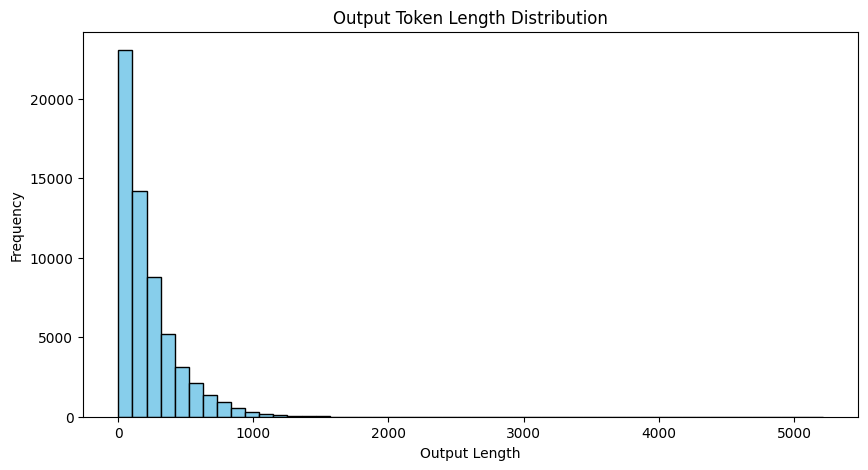

Max output token length: 5214
Min output token length: 2
Mean output token length: 219.43
Standard deviation of output token length: 217.96


In [21]:
plot_token_length(["input", "instruction", "output"])

# Preprocessing

In [22]:
dataset = dataset.shuffle(seed=CONFIG.seed)

In [23]:
dataset = dataset.map(formatting_func)
dataset = dataset.remove_columns(["instruction", "input", "output"])

In [24]:
print(dataset["train"][0]["text"])

<|start_header_id|>user<|end_header_id|>

이 시를 어떻게 분류하시겠습니까?
마거릿 애트우드의 "젊은 여자의 대답"

정답은 아니, 아니, 아니.
아니, 난 아직 놓을 준비가 안 됐어.
내가 묻어둔 희망과 꿈을
땅속 깊이 묻어두고
저를 기다리는 수평선을 향해.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

마거릿 애트우드의 시 '젊은 여자의 대답'은 독립과 주장이라는 주제를 강조하는 현대 자유시라고 할 수 있습니다. 이 시는 자신의 희망과 꿈을 포기하지 않는 강인하고 결단력 있는 여성의 성격을 잘 드러내고 있습니다. '아니오'라는 단어가 반복적으로 사용되어 도전적이고 대담한 느낌을 줍니다.


In [25]:
print(dataset["train"][1]["text"])

<|start_header_id|>system<|end_header_id|>

당신은 인공지능 비서입니다. 사용자가 답을 이해하기 위해 외부에서 검색할 필요가 없도록 자세한 답변을 제공하세요.<|eot_id|><|start_header_id|>user<|end_header_id|>

다음 질문에 답하세요: 이 리뷰를 바탕으로 이 제품을 추천하시겠습니까? === 리뷰: 디스크는 훌륭하게 날아가는 반면, 색칠과 스티커는 이미지에서 보는 것과는 다릅니다. 당신이 얻는 것은 그 멋진 스티커가 붙은 흰색 디스크입니다. 온라인에서 보는 것만 큼 좋지 않습니다. 그냥 일반 울트라스타를 구입하세요. 이것은 당신이 지불하는 추가 $ 4-5의 가치가 없습니다:

옵션:
(1). 아니요.
(2). 예.
답변:<|eot_id|><|start_header_id|>assistant<|end_header_id|>

리뷰에 따르면 사용자는 이 제품을 추천하지 않을 가능성이 높습니다. 색상과 스티커 디자인이 온라인 이미지와 일치하지 않는다고 언급하며, 4~5달러를 추가로 지불할 가치가 없으니 일반 울트라스타를 구입하는 것이 좋다고 제안합니다. 그래서 정답은 다음과 같습니다:

(1). No.


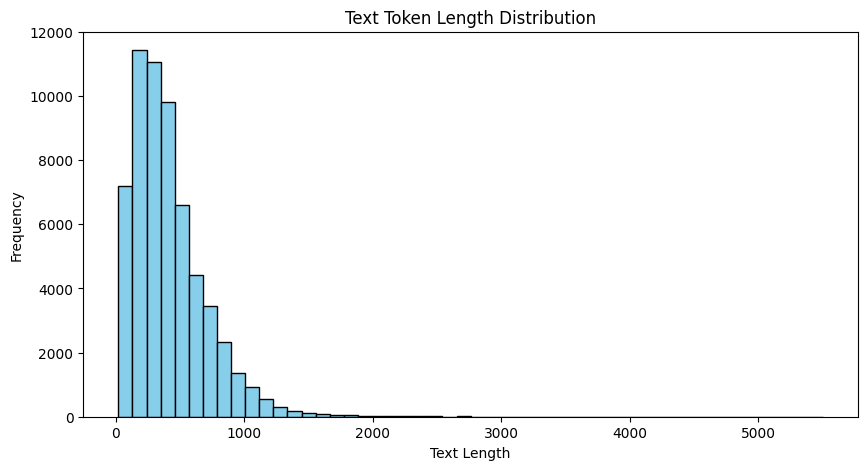

Max text token length: 5505
Min text token length: 22
Mean text token length: 416.93
Standard deviation of text token length: 297.82


In [26]:
plot_token_length(["text"])

In [27]:
dataset = dataset["train"].train_test_split(test_size=CONFIG.validation_size)

In [28]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 54054
    })
    test: Dataset({
        features: ['text'],
        num_rows: 6007
    })
})

In [29]:
torch.cuda.empty_cache()

# Supervised Fine-Tuning

In [30]:
training_args = SFTConfig(
    output_dir=CONFIG.output_dir,
    logging_dir=CONFIG.logging_dir,
    save_strategy=CONFIG.save_strategy,
    logging_strategy=CONFIG.logging_strategy,
    logging_steps=CONFIG.logging_steps,
    save_total_limit=CONFIG.save_total_limit,
    report_to=CONFIG.report_to,
    
    num_train_epochs=CONFIG.num_train_epochs,
    per_device_train_batch_size=CONFIG.per_device_train_batch_size,
    gradient_accumulation_steps=CONFIG.gradient_accumulation_steps,
    gradient_checkpointing=CONFIG.gradient_checkpointing,
    bf16=CONFIG.bf16,
    learning_rate=CONFIG.learning_rate,
    lr_scheduler_type=CONFIG.lr_scheduler_type,
    warmup_ratio=CONFIG.warmup_ratio,
    optim=CONFIG.optim,
    weight_decay=CONFIG.weight_decay,
    dataset_text_field="text",
    max_seq_length=CONFIG.max_seq_length
)

response_template = "<|start_header_id|>assistant<|end_header_id|>\n\n"
collator = DataCollatorForCompletionOnlyLM(
    tokenizer=tokenizer,
    response_template=response_template
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=collator
)

/home/pathfinder/anaconda3/envs/torch-env/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


In [31]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
10,1.661700
20,1.673100
30,1.672700
40,1.707300
50,1.645300
60,1.645800
70,1.707200
80,1.608000
90,1.766300
100,1.686100


/home/pathfinder/anaconda3/envs/torch-env/lib/python3.12/site-packages/trl/trainer/utils.py:156: UserWarning: Could not find response key `<|start_header_id|>assistant<|end_header_id|>

` in the following instance: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

귀하는 AI 어시스턴트입니다. 과제가 주어집니다. 상세하고 긴 답변을 생성해야 합니다.<|eot_id|><|start_header_id|>user<|end_header_id|>

뉴스 기사:

TV Everywhere를 위한 또 하나의 작은 발걸음이 시작되었습니다. 이제 미국 내 상위 10개 유료 TV 서비스 중 8곳을 통해 또 다른 태블릿인 Kindle Fire에서 HBO Go를 이용할 수 있게 됩니다.
  
 이는 전통적인 유료 TV 모델을 IP 디바이스 세계로 옮기려는 모기업 Time Warner의 노력의 선두주자인 프리미엄 케이블 회사가 TV에서 가장 관련성 높은 프로그램 브랜드로 다시 자리매김하는 과정에서 HBO의 또 하나의 점진적인 움직임일 뿐입니다.
  
 또한 읽어 보세요: 미리보기 - 킨들 파이어의 HBO Go가 아마존의 수익을 높이는 방법
  
 예, HBO는 10년 전과 마찬가지로 TV 비즈니스의 발전에 중요한 역할을 하고 있지만, 그 이유는 다릅니다. 획기적인 프로그램으로 TV 업계의 판도를 뒤흔드는 대신, 여전히 업계 최고의 2,900만 명의 고객을 보유한 가입자 지원 서비스가 이제 그 판도를 이끌고 있습니다.
  
 Xbox 360 게임 콘솔, iPad, Roku 셋톱, 그리고 이제는 유료 TV 사업자의 합의된 명단을 통해 Kindle Fire와 같은 Android 태블릿에서 이용할 수 있는 기존 TV에서 가장 널리 퍼진 브랜드로서 HBO Go의 운명

TrainOutput(global_step=6756, training_loss=1.3677676115041657, metrics={'train_runtime': 13892.3959, 'train_samples_per_second': 3.891, 'train_steps_per_second': 0.486, 'total_flos': 1.7938795980464947e+17, 'train_loss': 1.3677676115041657, 'epoch': 0.9998889998889999})

In [37]:
if not CONFIG.debug:
    trainer.save_model(CONFIG.model_name)
    wandb.finish()

# Inference

In [34]:
sample_system = "당신은 친절한 도우미입니다."
sample_user = "머신러닝이 무엇인가요?"
sample_generated_response = generate_instruct_model(sample_system, sample_user)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

당신은 친절한 도우미입니다.<|eot_id|><|start_header_id|>user<|end_header_id|>

머신러닝이 무엇인가요?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/pathfinder/anaconda3/envs/torch-env/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


머신 러닝(ML)은 컴퓨터 시스템을 통해 의사 결정과 데이터 분석을 수행할 수 있는 머신리더, 알고리즘 및 대화형 시스템의 자동화된 학습을 목적으로 하는 기술입니다. 주로 이미지, 문자 또는 숫자 데이터를 처리하여 문제를 해결하도록 훈련되는 딥러닝 모델의 집합으로, 이러한 시스템은 복잡하고 지능적인 작업에 대해 더 빠르고 효율적으로 이해할 수 있습니다. 머신러닝 알고리즘에는 분류, 회귀, 탐색적 학습 등 다양한 유형이 있으며, 데이터 분석 분야에서 일반적으로 사용됩니다. 머신러닝 알고리즘은 여러 단계를 거쳐야 하며, 데이터가 적고 예측에 대한 정확도가 낮거나 불일치하는 경우에만 사용됩니다. 또한 머신러닝 알고리즘은 인간의 사고 과정과 비슷하게 작동합니다. 따라서 ML은 데이터를 처리하고 신경망을 학습시키는 것처럼 사람의 생각을 추론하는 데도 사용될 수 있기 때문입니다. 마찬가지로 ML은 사람이 자신의 결정을 내리는 방식과 같으며, 사람들은 상황에 맞게 적절한 결정을 내리고, 사람들은 사람들의 생각을 더 잘 이해하기 위해 계속해서 그들의 생각을 바꿀 것입니다. 따라서 머신러닝 알고리즘이나 머신러닝의 의미는 사람의 정서와 같은 감정적 측면을 포함하지 않습니다. 하지만 머신러닝 알고리즘은 사람의 행동과 생각을 추론하는 데 매우 유용하며, 이는 인공지능의 발전으로 인해 개인의 삶에 매우 큰 영향을 미칠 수 있습니다. 즉, AI는 인간의 마음을 파악하는 능력을 갖추고 있어 보다 조용하고 편안하게 생활할 수 있도록 도와줄 수 있을 뿐만 아니라 우리에게 많은 이익을 가져올 수 있습니다. 다음은 머신러닝의 한 가지 예시인 딥러닝을 설명해 드릴 수 있습니다. 딥러닝은 컴퓨터 시스템을 통해 의사 결정과 데이터 분석을 수행할 수 있는 머신러닝 알고리즘의 일종이며, 이러한 시스템은 복잡하고 지능적인 작업에 대해 더 빠르고 효율적으로 이해할 수 있습니다. 딥러닝 알고리즘은 여러 단계를 거쳐야 합니다. 첫 번째 단계에서는 데이터 입력이 될 수 있으며, 여기에는 패턴을 찾고, 개별 데이

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7fe6716f49a0>
Traceback (most recent call last):
  File "/home/pathfinder/anaconda3/envs/torch-env/lib/python3.12/_weakrefset.py", line 39, in _remove
KeyboardInterrupt: 


KeyboardInterrupt: 

# Upload

In [39]:
if not CONFIG.debug:
    tokenizer.push_to_hub(
        repo_id=CONFIG.repo_id,
        use_temp_dir=False
    )
    model.push_to_hub(
        repo_id=CONFIG.repo_id,
        use_temp_dir=False
    )

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]